<a href="https://colab.research.google.com/github/romenlaw/generative/blob/main/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://ai.gopubby.com/you-dont-need-backpropagation-to-train-neural-networks-anymore-e989d75564cb

# NoProp
The NoProp algorithm borrows insights from [Diffusion models](https://arxiv.org/abs/1503.03585) (primarily used for image generation tasks) and applies them to an Image classification (supervised learning [link text](https://en.wikipedia.org/wiki/Supervised_learning)) task.

## 1. Stochastic Forward / Denoising Process
This process is represented by p as shown below:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*3flQoGDA25QeDGwRHEOFSw.png)

It models how we can start with noise and, through a series of steps, denoise it toward the final representation z(T)​, which is then used to predict the label y.

Mathematically, it is the joint probability of all intermediate noisy representations z(0), …, z(T) and the label y, given x.

In the equation:

* p(z(0)​) describes the standard Gaussian noise
* p(z(t) ∣ z(t−1), x) describes how each layer denoises the input noise
*p(y ∣ z(T)​) describes how y is classified based on the final representation z(T)
* p(z(t) ∣ z(t−1), x) is parameterized using a neural network as follows:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ChP3TlaZPSWv1KZup_Y7-g.png)

where:

* neural network û with parameters θ, weighted by a(t), predicts the denoised representation based on the noisy inputs z(t-1) and x
* b(t) ​⋅ z(t−1)​ represents a weighted skip connection
* √c(t) ​​⋅ ϵ(t)​ represents random Gaussian noise
* a(t), b(t), c(t) are scalers that are used to weigh the three different parts of the equation

## 2. Backward Nosing Process / Variational Posterior
This process is represented by q as shown below:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Lid_FWZZypM2E2PpoKmsLA.png)

It models how we can start with a label y (in the form of its embedding u(y)) and add noise step by step until we get the noise z(0).

Mathematically, it is the probability of the final noisy representation z(T) given the label y and input x.

In the equation:

* q(z(T) ​∣ y) describes the representation z(T) given label y
* xq(z(t−1) ​∣ z(t)​) describes the reverse diffusion process of reaching earlier noisy representations by adding more noise

q(z(T) ​∣ y) is given using the following equation:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*4zOeuxuZVaOV_H5v7FWigg.png)

This means that it is a Gaussian distribution over the latent variable z(T) where √αˉ(T)​​⋅ u(y)​ is the mean and 1 — αˉ(T) is the variance.

u(y) is the label embedding and αˉ(T)​ tells how much of u(y) remains after applying the noising process.

q(z(t−1) ​∣ z(t)​) is given by the following equation:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*MYg13gyFLi-sAwT9lGOhgg.png)

This means that it is a Gaussian distribution over the latent variable z(t-1) where √α(t-1)​​⋅ z(t)​ is the mean and 1 — α(t-1) is the variance.

α(t−1)​ is a noise scheduling parameter that controls how much of the original signal is preserved at timestep t-1.

Note that the terms α and αˉ come from a [fixed cosine](https://arxiv.org/abs/2102.09672) [noise schedule](https://arxiv.org/abs/2301.10972).

## Defining the Loss

The training objective of the NoProp algorithm is to maximise the log-likelihood of the correct label log⁡ p(y∣x).

But directly optimising this log-likelihood is computationally infeasible because it requires integrating over all possible high-dimensional latent variables z(0)​, … , z(T).

As a workaround, we instead maximise a variational lower bound on it called the [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound).

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*KZTSrhjpsEutwUe10yH7zg.png)

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*TKg00IjZp3-O6ECBh78zbw.png)

The NoProp loss is derived from this expression as:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*nJn4RJBQn5tmQp2Grshq2A.png)

(The mathematical details of this derivation are described in [Section A.4 of the original research paper.)](https://arxiv.org/pdf/2503.24322)

This looks very complex, but is easy to understand.

On the right-hand side of the equation:

* The first term is the **[Cross-entropy loss](https://en.wikipedia.org/wiki/Cross-entropy)**, which measures how accurately the final representation z(T) can be used to predict the correct label y.
* The second term is the **[Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)** between the distribution of the starting representation z(0) and the standard Gaussian noise distribution. This [regularization](https://www.ibm.com/think/topics/regularization) encourages both of these distributions to be similar, which is necessary for the diffusion process to work properly.
* The third term is the **layer-wise Denoising loss**, which measures how well each layer denoises by comparing how close its output is to the true label embedding (given by the L2 loss term).
In the equation, η is a hyperparameter and the term SNR is the Signal-to-Noise Ratio, given by the following equation:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Ye8uBABNhBpI88UzbYVpyw.png)

As t increases (as we move towards the later layers), the signal increases (noise decreases) and hence SNR increases. This makes the overall denoising loss larger.

This means that the model is penalized more for errors from the later layers (t closer to T) than the earlier ones.

## Training Process
During training, the network learns to denoise noisy label embeddings at each layer, without doing a full forward or backward pass through the network.

For a given input-label pair (x, y) an embedding matrix W(embed) maps the labels y to embeddings u(y) with each row of this matrix corresponding to the embedding u(y)​ of the label y.

Noise is first added to u(y) to create z(t).

Then, each neural network layer û(θ)(z(t−1) , x) is trained independently to denoise the previous noisy representation z(t-1)​ by predicting the clean embedding u(y) using input x.

The training loss is calculated, and the network parameters are updated while minimising this loss, using an optimiser.

The training algorithm is summarised using the pseudocode shown below.
![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*HZ_9Pj7Za98PH954LvLaIQ.png)

## Inference Process
During inference, the network with T total layers/ blocks is given Gaussian noise z(0).

Each layer, starting from Gaussian noise z(0), sequentially takes the output z(t-1) from the previous layer, and input x, to produce the next denoised representation z(t).

This results in a sequence of intermediate forms of the noise at each layer, represented by z(0)​, z(1)​, …, z(t), z(T-1), z(T)​.

At the final step t = T, the output z(T)​ is passed through a classifier to predict the final label ŷ.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*fcmo4yHdD48D-RDIeTSvWw.png)
z(0) is successively transformed towards z(T) with each layer represented by u(t) conditioned on input x, ultimately resulting in the the predicted label ŷ.


## Layer/Block Architecture

Each layer/ block û(θ)(z(t−1) , x), as described above, is a complex neural network in itself that takes:

* the input x and processes it through a [convolutional](https://en.wikipedia.org/wiki/Convolutional_neural_network) embedding module, followed by a fully connected layer
* noised representation from the previous layer z(t-1), and processes it using a fully connected network with skip connections

These inputs are then passed through additional fully connected layers to produce logits.

The logits go through a [softmax function](https://en.wikipedia.org/wiki/Softmax_function), producing a probability distribution over class embeddings.

The final output is obtained by computing a weighted sum of the class embeddings using this probability distribution.

![architecture](https://miro.medium.com/v2/resize:fit:720/format:webp/1*RVYlwvq1Q8obFInm5c1ekA.png)

## How Well Does NoProp Perform?
What we described above was the **Discrete-Time (DT)** variant of NoProp called **NoProp-DT**.

This is called so because it is implemented to model the diffusion process in discrete time steps, rather than continuously.

There are two other variants of it, namely:

* **NoProp-CT (Continuous-Time)**: This variant uses a continuous noise schedule and models the diffusion process over a continuous time span instead of discrete steps.
* **NoProp-FM (Flow Matching)**: This variant learns the vector field that transports noise towards the predicted label embedding via an [ordinary differential equation (ODE)](https://arxiv.org/abs/2210.02747), rather than the denoising approach.

All of these variants are compared with backpropagation and previous backpropagation-free methods for image classification tasks on three benchmark datasets:

* MNIST: A dataset of 70,000 grayscale images of handwritten digits (each 28 x 28 pixels), across 10 classes (digits 0–9)
* CIFAR-10: A dataset of 60,000 color images (each 32 x 32 pixels) across 10 different object classes
* CIFAR-100: A dataset of 60,000 color images (each 32 x 32 pixels) across 100 different object classes

Experiments show that NoProp achieves **performance comparable to or better than backpropagation and other backpropagation-free methods** on all three datasets.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*fUAsOxuOiAOiYHhdWPRd7A.png)

Alongside this, NoProp consumes less GPU memory during training as compared to other methods.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*54MkisKtuOXg3BXkmd1Ztw.png)




# Coding No-Prop From Scratch

In [1]:
import torch

if torch.backends.mps.is_available():
  device = torch.device("mps")
elif torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print ("device is ", device)

device is  cuda


## Defining the Denoising Block
This is the denoising neural network block (û(θ)) that takes:

* an image x
* a noisy intermediate representation z(t-1), and
* the class embedding matrix W_embed that contains label embeddings u(y) as
its rows

It then learns to denoise the noisy latent vector z(t-1) and bringing it closer to the true label embedding u(y) using information from the image x.

It returns the next representation z(t) given these inputs.

Unlike conventional neural networks, each of these blocks independently learn to remove noise towards the label embedding.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# Denoising block

class DenoiseBlock(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        # Image path
        self.conv_path = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256)
        )

        # Noisy embedding path
        self.fc_z1 = nn.Linear(embedding_dim, 256)
        self.bn_z1 = nn.BatchNorm1d(256)

        self.fc_z2 = nn.Linear(256, 256)
        self.bn_z2 = nn.BatchNorm1d(256)

        self.fc_z3 = nn.Linear(256, 256)
        self.bn_z3 = nn.BatchNorm1d(256)

        # Combined downstream path
        self.fc_f1 = nn.Linear(256 + 256, 256)
        self.bn_f1 = nn.BatchNorm1d(256)
        self.fc_f2 = nn.Linear(256, 128)
        self.bn_f2 = nn.BatchNorm1d(128)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x, z_prev, W_embed):
        # Image features
        x_feat = self.conv_path(x)

        # Features from noisy embedding
        h1 = F.relu(self.bn_z1(self.fc_z1(z_prev)))
        h2 = F.relu(self.bn_z2(self.fc_z2(h1)))
        h3 = self.bn_z3(self.fc_z3(h2))

        z_feat = h3 + h1 # Residual connection

        # Combine and predict logits
        h_f = torch.cat([x_feat, z_feat], dim=1)
        h_f = F.relu(self.bn_f1(self.fc_f1(h_f)))
        h_f = F.relu(self.bn_f2(self.fc_f2(h_f)))
        logits = self.fc_out(h_f)

        # Softmax on logits
        p = F.softmax(logits, dim=1)
        z_next = p @ W_embed

        return z_next, logits

## Defining the NonProp-DT Model

This model combines the label denoising through a T-step diffusion process, using independently trained DenoiseBlocks.

In [3]:
import math

# NoProp-DT model

class NoPropDT(nn.Module):
    def __init__(self, num_classes, embedding_dim, T, eta):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.T = T
        self.eta = eta

        # Stacking up the Denoise blocks
        self.blocks = nn.ModuleList([
            DenoiseBlock(embedding_dim, num_classes) for _ in range(T)
        ])

        # Class-embedding matrix (W_embed)
        self.W_embed = nn.Parameter(torch.randn(num_classes, embedding_dim) * 0.1)

        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

        # Cosine noise schedule
        t = torch.arange(1, T+1, dtype=torch.float32)
        alpha_t = torch.cos(t / T * (math.pi/2))**2
        alpha_bar = torch.cumprod(alpha_t, dim=0)
        snr = alpha_bar / (1 - alpha_bar)
        snr_prev = torch.cat([torch.tensor([0.], dtype=snr.dtype), snr[:-1]], dim=0)
        snr_diff = snr - snr_prev

        self.register_buffer('alpha_bar', alpha_bar)
        self.register_buffer('snr_diff', snr_diff)

    def forward_denoise(self, x, z_prev, t):
        return self.blocks[t](x, z_prev, self.W_embed)[0]

    def classify(self, z):
        return self.classifier(z)

    def inference(self, x):
        B = x.size(0)
        z = torch.randn(B, self.embedding_dim, device=x.device)

        for t in range(self.T):
            z = self.forward_denoise(x, z, t)

        return self.classify(z)

## Defining the Training Function
This function trains the NoProp-DT model (creating by combining T Denoising blocks without using backpropagation.

In [4]:
import matplotlib.pyplot as plt

# Function for training NoProp-DT

def train_nopropdt(model, train_loader, test_loader, epochs, lr, weight_decay):
    # Using AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Dict to store metrics
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        model.train()

        for t in range(model.T):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                uy = model.W_embed[y]
                alpha_bar_t = model.alpha_bar[t]
                noise = torch.randn_like(uy)
                z_t = torch.sqrt(alpha_bar_t) * uy + torch.sqrt(1 - alpha_bar_t) * noise

                z_pred, _ = model.blocks[t](x, z_t, model.W_embed)
                loss_l2 = F.mse_loss(z_pred, uy)
                loss = 0.5 * model.eta * model.snr_diff[t] * loss_l2

                if t == model.T - 1:
                    logits = model.classifier(z_pred)
                    loss_ce = F.cross_entropy(logits, y)
                    loss_kl = 0.5 * uy.pow(2).sum(dim=1).mean()
                    loss = loss + loss_ce + loss_kl

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        # Training accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                preds = model.inference(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        train_acc = correct / total

        # Validation accuracy
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model.inference(x).argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total

        # Storing accuracy history
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{epochs}  "
              f"TrainAcc={100 * train_acc:.2f}%  ValAcc={100 * val_acc:.2f}%")

    # Plotting Training and Validation accuracy
    plt.figure()
    plt.plot(range(1, epochs + 1), history['train_acc'], label='Train Accuracy')
    plt.plot(range(1, epochs + 1), history['val_acc'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n Final Test Accuracy: {100 * val_acc:.2f}%")

## Defining Hyperparameters
The hyperparameters used by the authors in their experiments are shown below.
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*kOK_VvPVi2huiBrlF9lxMg.png)

There’s just a minor change: we're training the model for only 10 epochs instead of 100, as this amount of training is sufficient to achieve satisfactory results for our tutorial.

In [5]:
# Hyperparameters

T = 10
eta = 0.1
embedding_dim = 512
batch_size = 128
lr = 1e-3
epochs = 10
weight_decay = 1e-3

## Loading MNIST Dataset
We will not apply data augmentation techniques on the MNIST dataset. This is similar to the experiments from the original research paper.

In [6]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision

# Loading MNIST

transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.53MB/s]


## Initialising the Model

Let’s set up the model with the hyperparameters that we defined.

In [7]:
# Initializing model

model = NoPropDT(num_classes=10, embedding_dim=embedding_dim, T=T, eta=eta).to(device)

## Training the Model

Epoch 1/10  TrainAcc=92.86%  ValAcc=92.93%
Epoch 2/10  TrainAcc=97.11%  ValAcc=96.76%
Epoch 3/10  TrainAcc=98.18%  ValAcc=98.03%
Epoch 4/10  TrainAcc=98.81%  ValAcc=98.56%
Epoch 5/10  TrainAcc=98.82%  ValAcc=98.54%
Epoch 6/10  TrainAcc=99.03%  ValAcc=98.79%
Epoch 7/10  TrainAcc=99.15%  ValAcc=99.03%
Epoch 8/10  TrainAcc=99.06%  ValAcc=98.75%
Epoch 9/10  TrainAcc=99.04%  ValAcc=98.68%
Epoch 10/10  TrainAcc=99.30%  ValAcc=98.96%


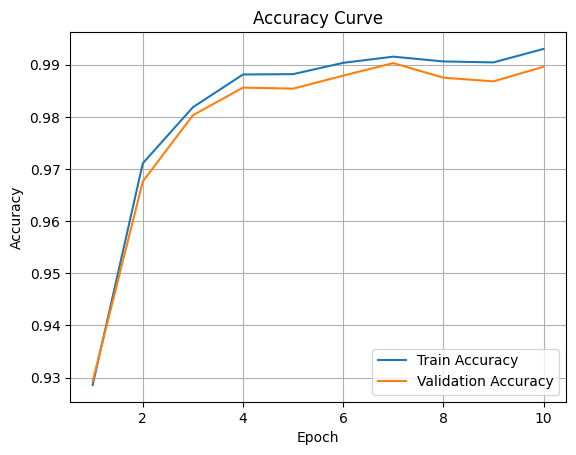


 Final Test Accuracy: 98.96%


In [8]:
# Begin training

train_nopropdt(model, train_loader, test_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)

## Visualising Predictions

In [9]:
# Function to plot predictions

def show_predictions(model, test_loader, class_names=None, num_images = 16):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model.inference(x)
            preds = logits.argmax(dim=1)

            for i in range(x.size(0)):
                if images_shown >= num_images:
                    break

                plt.subplot(int(num_images**0.5), int(num_images**0.5), images_shown + 1)
                img = x[i].cpu().squeeze(0)
                plt.imshow(img, cmap='gray')
                actual = class_names[y[i]] if class_names else y[i].item()
                pred = class_names[preds[i]] if class_names else preds[i].item()
                plt.title(f"Pred: {pred}\nTrue: {actual}", fontsize=8)
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

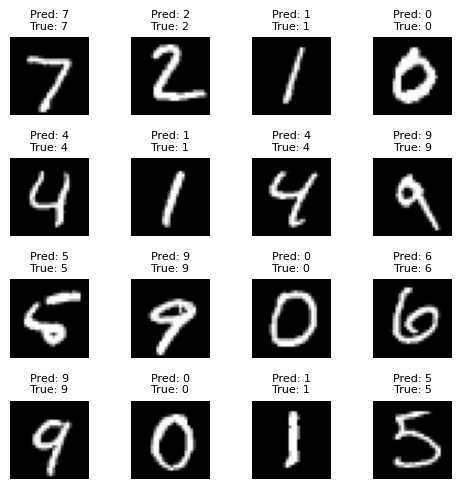

In [10]:
# Class names for MNIST dataset
class_names = [str(i) for i in range(10)]

# Visualising predictions
show_predictions(model, test_loader)

#Further Reading
* [Research paper titled ‘NoProp: Training Neural Networks without Back-propagation or Forward-propagation’ published in ArXiv](https://arxiv.org/abs/2503.24322)
* [Notebook containing the code for training a neural network with NoProp-DT on the MNIST dataset](https://github.com/ashishbamania/Tutorials-On-Artificial-Intelligence/blob/main/Training%20Without%20Backpropagation/NoPropDT_on_MNIST.ipynb)
* [Research paper titled ‘Denoising Diffusion Probabilistic Models’ published in ArXiv](https://arxiv.org/abs/2006.11239)
* [Research paper titled ‘Deep Unsupervised Learning using Nonequilibrium Thermodynamics’ published in ArXiv](https://arxiv.org/abs/1503.03585)
* [Research paper titled ‘Learning representations by back-propagating errors’ published in Nature](https://www.nature.com/articles/323533a0)